# EECS 598 Lab 2: Exploring Environments and Action Spaces in Mujoco Playground

![lab2_poster](lab2_poster.png)

This notebook is worth **80 points**. Questions and implementation are marked with relevent `#TODO(student)` markers.

**Due:** Friday, Sep 5 @ 1pm


Before starting the assignment, please put your name and UMID in the following format:

Firstname LASTNAME, #00000000 (ex. Drew SCHEFFER #31415926)

**YOUR ANSWER BELOW**

Justin LU, #85477350

## Setup

In [ ]:
import sys, types, importlib

# Create a tiny fake 'imp' module exposing only 'reload'
_imp = types.ModuleType("imp")
_imp.reload = importlib.reload
sys.modules["imp"] = _imp

# load autoreload
%load_ext autoreload
%autoreload 2

In [ ]:
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

In [ ]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

### Google Colab Setup

Next, we'll run a few fommands to set up the environment on Google Colab. If you are running this notebook locally you can skip this section

Run the following to mount this notebook to your Google Drive. Follow the link and sign into the Google account following the prompts. Use the same Google account that you used to store this notebook. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Now update the path below to point to the folder in your Google Drive where you uploaded this notebook. If everything worked correctly you should see the following filenames: [`custom_env.py`, `02_lab.ipynb`]

In [ ]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded project 2
# Example: If you create a 2025FA folder and put all the files under Lab2, then '2025FA/Lab2'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2025FA/Lab2'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
GOOGLE_DRIVE_PATH_LAB2 = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

print(os.listdir(GOOGLE_DRIVE_PATH_LAB2))

# Add to path and change directory for good measure
sys.path.append(GOOGLE_DRIVE_PATH_LAB2)
os.chdir(GOOGLE_DRIVE_PATH_LAB2)

In [ ]:
from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

## Mujoco Setup & Imports

In [ ]:
# DO NOT RUN THIS CELL IF RUNNING NOTEBOOK INSIDE DOCKER CONTAINER!
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

In [ ]:
# DO NOT RUN THIS CELL IF RUNNING NOTEBOOK INSIDE DOCKER CONTAINER!

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

In [1]:
#@title Import MuJoCo, MJX, and Brax
from datetime import datetime
from etils import epath
import functools
from IPython.display import HTML
from typing import Any, Dict, Sequence, Tuple, Union
import os
from ml_collections import config_dict


import jax
from jax import numpy as jp
import numpy as np
from flax.training import orbax_utils
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from orbax import checkpoint as ocp

import mujoco
from mujoco import mjx

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

## Introduction to Mujoco & MJX

MJX is an implementation of MuJoCo written in [JAX](https://jax.readthedocs.io/en/latest/index.html). The appeal of MJX is that it enables large batch simulation on GPU/TPU, which is especially suitable for reinforcement learning workloads. For today, however, we'll mainly look past the fast rendering of MJX and focus on creating basic simulation environments and agents.

The best way to learn about MJX/Mujoco is to get our hands dirty! Let's create a simple mujoco world using their XML system to get a sense of what is required.

In [2]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""

# Load the model, get the data, then render
mj_model = mujoco.MjModel.from_xml_string(xml)
mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model)

A few very important structures have already showed up: 
1. `mj_model`: A compiled model of the XML. This contains quantities that DO NOT change over time. For a list of everything that can be stored in this variable see [`mjmodel.h`](https://github.com/google-deepmind/mujoco/blob/main/include/mujoco/mjmodel.h)
2. `mj_data`: simulation state (i.e. positions, velocities, forces, etc)
3. `renderer`: a CPU renderer for visualization

#### `mjModel`

A compiled model of the XML. This contains quantities that DO NOT change over time. For a list of everything that can be stored in this variable see [`mjmodel.h`](https://github.com/google-deepmind/mujoco/blob/main/include/mujoco/mjmodel.h)

In [3]:
# mj_model examples
print("num geoms:", mj_model.ngeom)
print("geom colors:", mj_model.geom_rgba)

mj_model.geom("green_sphere")

num geoms: 2
geom colors: [[1. 0. 0. 1.]
 [0. 1. 0. 1.]]


<_MjModelGeomViews
  bodyid: array([1], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([-1], dtype=int32)
  friction: array([1.e+00, 5.e-03, 1.e-04])
  gap: array([0.])
  group: array([0], dtype=int32)
  id: 1
  margin: array([0.])
  matid: array([-1], dtype=int32)
  name: 'green_sphere'
  pos: array([0.2, 0.2, 0.2])
  priority: array([0], dtype=int32)
  quat: array([1., 0., 0., 0.])
  rbound: array([0.1])
  rgba: array([0., 1., 0., 1.], dtype=float32)
  sameframe: array([3], dtype=uint8)
  size: array([0.1, 0. , 0. ])
  solimp: array([9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([2], dtype=int32)
  user: array([], dtype=float64)
>

Each element in the scene is given a unique ID that can be used to access its quantities. 

In [4]:
geom_name = "green_sphere"

# TODO(student): given the name of a geom, access its color
#       use the function mujoco.mj_name2id and the mj_model.geom_rgba property

# Get unique ID using mj_name2id
geom_id = mujoco.mj_name2id(
    mj_model,
    mujoco.mjtObj.mjOBJ_GEOM, # Specify to look for a geom
    geom_name
)

# Get color using ID to index
geom_color = mj_model.geom_rgba[geom_id]

answer = geom_color
print("Answer = ", answer[:3] * 255, "(RGB)")

Answer =  [  0. 255.   0.] (RGB)


#### `mjData` 

contains the *state* of the environment and the quantities that depend on it. The state is made up of time, *generalized* positions, and *generalized* velocities in a configuration space. You can access these quantities via `data.time`, `data.qpos`, and` data.qvel` respectively. `mjData` also contains *functions of the state*, for example cartesian positions of the objects in the world frame. 

In [5]:
data = mujoco.MjData(mj_model)
print(data.geom_xpos)

[[0. 0. 0.]
 [0. 0. 0.]]


This output above might look counterintuitive. If you recall, in the XML we explicitly set the cartesian positions in the world frame, right? Well, it turns out that derived quantities in `mjData` need to be explicitly propagated. In this simple case the minimal required function is `mj_kinematics` which compultes global Cartesian poses for all objects. 

In [6]:
mujoco.mj_kinematics(mj_model, data)
print('raw access:\n', data.geom_xpos)

# MjData also supports named access:
print('\nnamed access:\n', data.geom('green_sphere').xpos)

raw access:
 [[0.         0.         0.        ]
 [0.27320508 0.07320508 0.2       ]]

named access:
 [0.27320508 0.07320508 0.2       ]


#### Rendering a Simple Environment Rollout on the CPU

First, let's see how to render a rollout using the CPU simulation. Feel free to poke around and explore the different variables. 

Pay attention to the use of the functions `mujoco.mj_resetData` and `mujoco.mj_step` and connect them to what we learned above. 

In [7]:
# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 5  # (s)
framerate = 60  # (Hz)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
while mj_data.time < duration:
  mujoco.mj_step(mj_model, mj_data)
  if len(frames) < mj_data.time * framerate:
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

#### Rendering the Same Simple Environment Rollout on the GPU
Now let's try doing the same thing on the GPU using Jax! First, we put the model and the data on the GPU

In [8]:
mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)

See how the data types change

In [9]:
print(mj_data.qpos, type(mj_data.qpos))
print(mjx_data.qpos, type(mjx_data.qpos), mjx_data.qpos.devices())

[-4.02848658] <class 'numpy.ndarray'>
[-4.0284867] <class 'jaxlib.xla_extension.ArrayImpl'> {CudaDevice(id=0)}


In the example below, we use `mjx.step` instead of `mujoco.mj_step`, and we also [`jax.jit`](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html) the `mjx.step` so that it runs efficiently on the GPU. For each frame, we convert the `mjx.Data` back to `mjData` so that we can use the MuJoCo renderer.

In [10]:
jit_step = jax.jit(mjx.step)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
mjx_data = mjx.put_data(mj_model, mj_data)
while mjx_data.time < duration:
  mjx_data = jit_step(mjx_model, mjx_data)
  if len(frames) < mjx_data.time * framerate:
    mj_data = mjx.get_data(mj_model, mjx_data)
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

Interestingly, rendering this simple simulation on the GPU is not very efficient as you might have noticed. The GPU simulation likely took >10x the amount of time! Running single-threaded physics simulation is not efficient compared to a high performance CPU. The advantage of MJX in general is that we can run **many, many** environments in parallel on a GPU/TPU. 

[Read this if you want to learn more](https://mujoco.readthedocs.io/en/stable/mjx.html#mjx-the-sharp-bits)

as a test, let's render 1000 steps of the physics simulation for 4096 parallel envs...

In [11]:
import time 

NUM_ENVS = 4096

start_time = time.time()
rng = jax.random.PRNGKey(0)
rng = jax.random.split(rng, NUM_ENVS)
batch = jax.vmap(lambda rng: mjx_data.replace(qpos=jax.random.uniform(rng, (1,))))(rng)
jit_step = jax.jit(jax.vmap(mjx.step, in_axes=(None, 0)))

num_steps = 1000
for i in range(num_steps):
    batch = jit_step(mjx_model, batch)

print("The frames per second is ", NUM_ENVS*num_steps / (time.time() - start_time))

The frames per second is  621474.7115383989


`TODO(student)` **TASK 1**: describe in your own words how jax random numbers work. What is the purpose of `jax.random.split`? (5 pts)

**Answer:**
- In JAX, there is no 'hidden global state' for random number generation like there is in NumPy.
What this means is we can't just set the seed once and then repeatedly call some `rand()` function (like in NumPy).

- Instead, we explicitly get a global key (`key = jax.random.PRNGKey(seed number)`), then we call `jax.random.split(key)`, which returns bunch of single-use keys.
        
- Then, we can simply use said sub-keys (`jax.random.normal(key1 or key2 or key3)`) in our code to pseudorandomly generate numbers.

- Reproducibility is absolutely crucial when working with neural networks that run in massively-parallel environments (with domain randomization at that), which is exactly what we are doing.

## Loading an Environment and Agent

The loading and initialization of the simulation world and its agents are largely handled in our *environment file*. In our case, the environment file is [`custom_env.py`](./custom_env.py). Check out this file for a few minutes, looking at the main functions that it implements. Especially `render()`, `step()`, `get_obs()`, and `reset()`. 

In [12]:
from custom_env import UnitreeGo2Env
from custom_env import UNITREEGO2_ROOT_PATH

envs.register_environment('unitreego2', UnitreeGo2Env)

print("List the assets used to create the simulation environment")
os.listdir(UNITREEGO2_ROOT_PATH)

List the assets used to create the simulation environment


['scene_mjx.xml',
 'CHANGELOG.md',
 'assets',
 'go2.png',
 'go2_mjx.xml',
 'README.md',
 '.DS_Store',
 'go2.xml',
 'scene.xml',
 'go2_mjx.png',
 'LICENSE']

Load the environment and agent, then render the scene.

In [13]:
# instantiate the environment
env_name = 'unitreego2'
env = envs.get_environment(env_name)

# jit reset/step functions for fast runtime
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

/usr/local/lib/python3.12/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


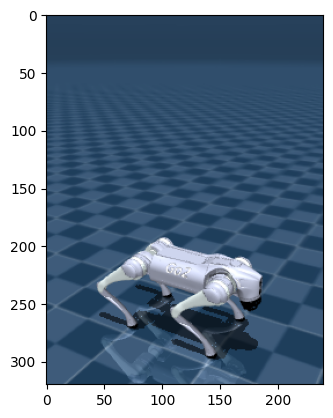

In [14]:
state = jit_reset(jax.random.PRNGKey(0))

plt.imshow(env.render([state.pipeline_state], camera='track')[0])

`TODO(student)` **TASK 2**: Similarly, we can rollout an entire trajectory in our environment using the `jit_step()` function. **(10 pts)**

In [15]:
state = jit_reset(jax.random.PRNGKey(0))

rollout = [state.pipeline_state]

# grab a trajectory
for i in range(500):
    
    # TODO(student): Sample the ZERO action for the robot. For now, just create a `jax.array` 
    # with the same size as the number of actuators. Set each element of the array to be 0. 
    # hint 1: you can use the `env.sys.nu` property to get the number of actuators/motors
    # hint 2: the `jp` module is an alias for jax.numpy which has similar functionality to 
    # numpy (i.e. jp.zeros, jp.ones, jp.array, etc)
    action = jp.zeros(12) # Literally just a zero action
    
    # TODO(student): Take a "jit_step" in the environment. See the custom_env.py file for details 
    # on the arguments the function takes and what it returns. 
    state = jit_step(state=state, action=action)
    
    rollout.append(state.pipeline_state)

media.show_video(env.render(rollout, camera="track"), fps=1.0 / env.dt)

### Randomize the Starting Pose of the Robot

That's pretty cool! Our agent has successfully been loaded into the environment! One reasonable next step is to control where the agent is spawned into the environment. 

`TODO(student)` **TASK 3**: Navigate to the `custom_env.py` file and fill out the `TODO(student)` related to spawning the agent in different positions. **(10 pts)**

In [16]:
from custom_env import UnitreeGo2Env

env_rand = envs.get_environment("unitreego2", randomize_initial_pos=True)

# jit reset/step functions for fast runtime
jit_reset = jax.jit(env_rand.reset)
jit_step = jax.jit(env_rand.step)
state = jit_reset(jax.random.PRNGKey(2))

rollout = [state.pipeline_state]

# grab a trajectory
for i in range(500):
    action = jp.zeros(env_rand.sys.nu)
    state = jit_step(state, action)
    rollout.append(state.pipeline_state)

media.show_video(env_rand.render(rollout, camera="track"), fps=1.0 / env_rand.dt)

## Exploring the state and action space

In this section, we'll begin to explore how to use and modify the agent's *state* and *action* spaces. First, I encourage you to simply play with the robot model. What does the `action` variable seem to represet? 

In [18]:
env = envs.get_environment("unitreego2")

# jit reset/step functions for fast runtime
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)


state = jit_reset(jax.random.PRNGKey(0))

state = jit_reset(jax.random.PRNGKey(0))

rollout = [state.pipeline_state]

# grab a trajectory
for i in range(500):
    # TODO(student): Modify and change the action below, think about what happens. What happens? 
    # What does the zero action do? How is it defined? 
    action = jp.zeros(env.sys.nu)
    
    # Take a step in the environment
    state = jit_step(state, action)
    
    
    rollout.append(state.pipeline_state)

media.show_video(env.render(rollout, camera="track"), fps=1.0 / env.dt)

`TODO(student)` **TASK 4**: How is the "action" defined in this environment? What do the values in the `action` variable represent? **(5 pts)**

**Answer:** Given that a zero action made the robot stand in its default pose, the values inside `action` must be a list of "joint positional deltas". 

- In simpler terms, `action` is a list that contains 12 radian values (one for each Go2 joint), where each value is how much a joint should **deviate from its default position**.

- In practice this is just done by adding the values of `actions` to whatever list contains the default robot joint positions, then using the result as a target for your (simulated) joint PD controller.

After exploring, fill out the following with your answers: **(5 pts)**

In [ ]:
#TODO: Fill out the following
initial_joint_values = None
min_joint_values = None
max_joint_values = None

print("Answers:", initial_joint_values, min_joint_values, max_joint_values)

We get access to the robot "state" after each environment step. The `pipeline_state` is stored in the `rollout` array. 

`#TODO(student)` **TASK 5**: Play around with the data and plot the right foot position over time using matplotlib (10 pts)

In [ ]:
# TODO(student): Use the "rollout" variable to plot the position of the front 
# right foot over time while performing some non-zero action

import mujoco
import matplotlib.pyplot as plt

#TODO(student). Use the function mujoco.mj_name2id to get the geom id of the front right foot. 
# You can find an in the custom_env.py file, however, the "type" parameter will no longer be a body, but a geom. 
fr_foot_geom_id = None

foot_poses = []

for state in rollout:
    # TODO(student): access the position of the front right foot using the fr_foot_geom_id you calculated. 
    # hint: remember the xyz position of geoms are stored in the geom_xpos property of the MjData object.
    foot_pos = None
    foot_poses.append(np.array(foot_pos))
    
    

foot_poses = np.stack(foot_poses)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.show()

## Modifying the Environment Class (and kicking your robot)

In this section, we'll get more experience changing the environment directly! Up until now, the robot lives in its lonely world undisturbed. Let's change that! 

In many simulated environments, researchers will inflict periodic, random "pushes" in an effort to make their robots more robust to external disturbances. You'll code up a simple version of this behavior in our environment! 

`TODO(student)` **TASK 6**: Head over to [`custom_env.py`](./custom_env.py) and impliment the "kick" TODOs at the top of the `step()` function. (10 pts)

In [ ]:
from custom_env import UnitreeGo2Env

env = envs.get_environment("unitreego2", kick_vel=0.5)

# jit reset/step functions for fast runtime
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
state = jit_reset(jax.random.PRNGKey(0))

state = jit_reset(jax.random.PRNGKey(0))

rollout = [state.pipeline_state]
all_obs = [state.obs]
all_infos = [state.info]

# grab a trajectory
for i in range(500):
    action = jp.zeros(env.sys.nu) # Don't modify
    
    # Take a step in the environment
    state = jit_step(state, action)
    
    
    rollout.append(state.pipeline_state)
    all_obs.append(state.obs)
    all_infos.append(state.info)

media.show_video(env.render(rollout, camera="track"), fps=1.0 / env.dt)

Above, after you've implimented the "kick" mechanic to the env, you should see the robot occasionally being pushed in random directions!

`#TODO(student)` **TASK 7**: Since you also added each kick to the robot's observation, plot the norm of the kick vector against time using the `all_infos` variable. (5 pts)



In [ ]:
#TODO(student): Plot the kick magnitude vs time
kicks = []

kicks = np.array(kicks)

plt.figure(figsize=(12, 3))
plt.plot(kicks, marker='o')
plt.title("Array values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

plt.imshow(np.zeros((200, 200)))

## Modifying the Agent

`#TODO(student)` **TASK 8**: Time to get creative! Change the agent model (`unitree_go2/go2_mjx.xml`) in some way! It can be changing the mesh colors, skybox, or adding enitrely different links! (5 pts)

For an extra challenge, try to add an attribute that is actuated (e.g. a tail, eyes, etc)! 

**WARNING:** make sure to change the agent back if you make any big changes so the next steps work. 

In [ ]:
env_name = 'unitreego2'
env = envs.get_environment(env_name)

# jit reset/step functions for fast runtime
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

state = jit_reset(jax.random.PRNGKey(0))

plt.imshow(env.render([state.pipeline_state], camera='track')[0])

## Make the Robot Sit on Its Hind Legs

The goal of this section is to get the robot to sit on its hind legs. 

`TODO(student)` **TASK 9**: Use what you've you learned in this notebook to make this custom controller. (5 pts)

As a starting point, I've already defined a `sit` keyframe in the [`unitree_go2/go2_mjx.xml`](./unitree_go2/go2_mjx.xml) file. Can you figure out how to use it? 

In [ ]:
from custom_env import UnitreeGo2Env

# TODO(student): Make a video of a robot sitting on its hind legs!
# Make sure the kick_vel is set to 0 so the robot doesn't fall over
sit_env = envs.get_environment("unitreego2", kick_vel=0)

# jit reset/step functions for fast runtime
jit_reset = jax.jit(sit_env.reset)
jit_step = jax.jit(sit_env.step)
state = jit_reset(jax.random.PRNGKey(0))

rollout = [state.pipeline_state]
all_obs = [state.obs]
all_infos = [state.info]



for i in range(500):
    action = jp.zeros(sit_env.sys.nu) 
    
    # Take a step in the environment
    state = jit_step(state, action)

    rollout.append(state.pipeline_state)

media.show_video(sit_env.render(rollout, camera="track2"), fps=1.0 / sit_env.dt) # NOTE: Use the track2 camera to get a head-on shot

## Drawing General Shapes with the Right Hand

In this last section, we'll be going one step beyond specifying joint position setpoints for making motions on the simulated robot. 

`#TODO(student)` **TASK 10**: You are tasked with using the front right hand to "draw" some shape of your chosing in simulation. (10 pts)

As a starting point you can use a basic implimentation of numerical [Inverse Kinematics](https://en.wikipedia.org/wiki/Inverse_kinematics) (see [`ik.py`](./ik.py)). 

The function `solve_ik(foot_world_pos)` takes as input a desired position of the right foot in the world frame. It then tries to solve for the go2's right leg joints that achieve that position. In other words, it's a mapping between world frame coordinates and the robot's joint angles. Note that if the world frame position is not reachable, the `solve_ik()` function will not converge and will be stuck at some local minima. 

You can use this mapping to create your shape in cartesian coordinates, then map them to joint angles that can be achieved by the simulated robot. Feel free to make your own shape (e.g, heart, butterflys, leminscates, etc)! 

In [ ]:
from ik import IKSolver

# NOTE: the render_foot_cursor argument makes the environment render a trace of the front right foot
sit_env = envs.get_environment("unitreego2", render_foot_cursor=True, keyframe_name="sit", kick_vel=0)

jit_reset = jax.jit(sit_env.reset)
jit_step = jax.jit(sit_env.step)

In [ ]:
# TODO(student): Impliment everything you need to draw your shape. 

# Hint: to use the IKSolver, first define an instance of the 
# class `ik_solver = IKSolver()` then call `ik_solver.solve_ik(sit_env._init_q, numpy_xyz_world_pos)`

state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]

q_initial = sit_env._init_q

# grab a trajectory
num_steps = 400
for i in range(num_steps):
    pass

In [ ]:
media.show_video(sit_env.render(rollout, width=480, height=480, camera="track2"), fps=1.0 / sit_env.dt)

## What to Turn In

`#TODO(student):` Please zip the following files and turn them into the assignment on gradescope:
1. your `02_lab_student.ipynb` file. Please make sure to fill our your name and umich ID in the first cell
2. your modified `custom_env.py` file.